In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import precision_recall_fscore_support
#from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')


In [2]:
contra = pd.read_csv("contraceptive/contraceptive_for_students.csv")

1. Wife's age (numerical)
2. Wife's education (categorical) 1=low, 2, 3, 4=high
3. Husband's education (categorical) 1=low, 2, 3, 4=high
4. Number of children ever born (numerical)
5. Wife's religion (binary) 0=Non-Islam, 1=Islam
6. Wife's now working? (binary) 0=Yes, 1=No
7. Husband's occupation (categorical) 1, 2, 3, 4
8. Standard-of-living index (categorical) 1=low, 2, 3, 4=high
9. Media exposure (binary) 0=Good, 1=Not good
10. Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term


In [3]:
contra.head()

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [4]:
contra.isna().sum()

wife_age              0
wife_education        0
husband_education     0
num_child             0
wife_religion         0
wife_work             0
husband_occupation    0
standard_living       0
media_exposure        0
contraceptive         0
dtype: int64

*There are no null values in the code, so there is no need to drop or impute any of the values* 

In [5]:
contra['type'] = contra['contraceptive'].replace({1: 'No Use', 2: "Long Term", 3 : "Short Term"})

In [6]:
def phi0(X, columns):

    for column in columns:
        X[column] = standardize(X[[column]])[column]
#         X['tanh(' + column + ')'] = np.tanh(X[column])
#         X[column + "^2"] = X[column]**2
# #         X[column + "^3"] = X[column]**3
# #         X[column + "^4"] = X[column]**4
# #         X[column + "^5"] = X[column]**4
# #         X["sqrt(" + column + ")"] = np.sqrt(X[column])
    return X

In [7]:
def design(X, featurize = phi0):
    X = X.copy()
   
    categorical = X.copy()[['wife_education', 'husband_education', 'husband_occupation',
       'standard_living']]
    other = contra[['wife_age', 'num_child', "wife_work", "media_exposure"]]

    #one hot encode the categorical data
    encoder = preprocessing.OneHotEncoder()
    one_hot = pd.DataFrame(encoder.fit_transform(categorical).toarray())
    ohe_columns = ["wife_edu1", "wife_edu2", "wife_edu3", "wife_edu4", "hus_edu1", "hus_edu2", "hus_edu3", "hus_edu4", 
           "hus_occ1", "hus_occ2", "hus_occ3", "hus_occ4", "std_living1", "std_living2", "std_living3", 
           "std_living4"]
    one_hot.columns = ohe_columns
    contra_clean = other.join(one_hot)
    return featurize(contra_clean, columns = ['wife_age', 'num_child'])

## EDA

#### First we will check the proportions of the classes

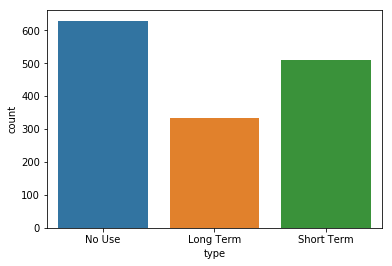

In [8]:
sns.countplot(data=contra, x = 'type')

#### Correlation between Features

Text(0.5, 1.0, 'Correlation between features')

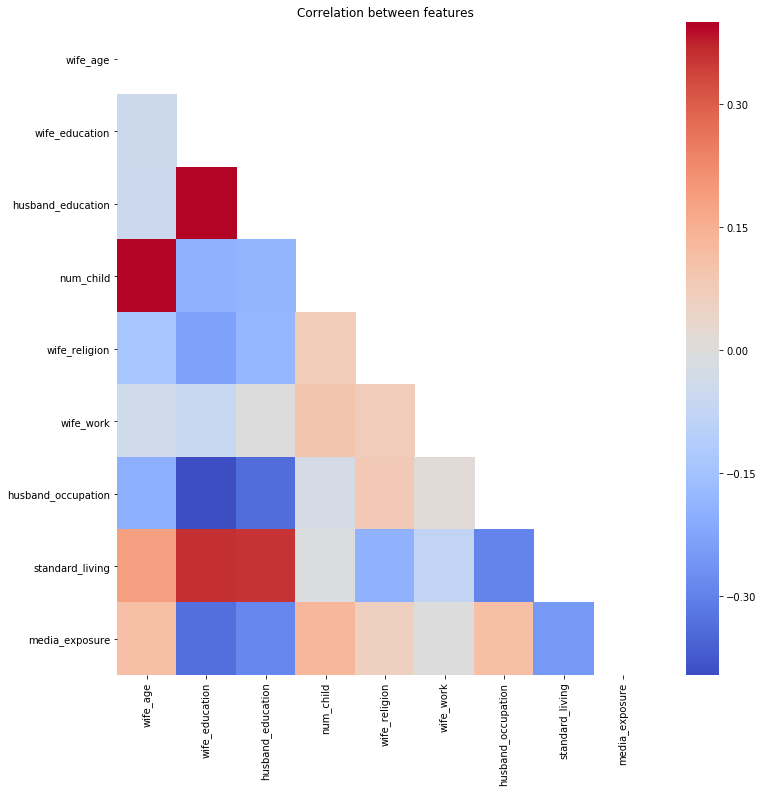

In [9]:
# Compute the correlation matrix
corr = contra.copy().drop(columns=['contraceptive']).corr()

#Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.4, center=0).set_title("Correlation between features")

In [10]:
def standardize(data, with_std = True):
    scaler = preprocessing.StandardScaler(with_std = with_std)
    columns = data.columns
    df = pd.DataFrame(scaler.fit_transform(data))
    df.columns = columns
    return df

In [11]:
def pca_plot(df, plot = 'scree', with_std = True):
    df_std = standardize(df.copy(), with_std)
    u, s, vt = np.linalg.svd(df_std, full_matrices=False)
    #pcs = df @ vt[:2].T
    pcs = df @ vt.T
    hues = contra['contraceptive'].replace({1: 'No Use', 2: "Long Term", 3 : "Short Term"})
    if plot == 'scree':
        plt.plot(range(1, len(s) + 1), s**2/sum(s**2))
        plt.xticks(range(1, len(s) + 1))
        plt.title("Proportion of Variance vs Principal Component #")
        plt.xlabel("Principal Component #")
        plt.ylabel("Proportion of Variance");
    elif plot == 'first':
        #project data to first pc and plot
        sns.stripplot(x = hues, y= pcs[0])
        plt.title("Strip Plot of Principal Component 1")
        plt.ylabel("PC 1 Value")
    elif plot == 'second':
        pcs = df @ vt[:2].T
        fig = sns.scatterplot(x = pcs[0], y = pcs[1], hue = hues, palette = 'coolwarm', legend = 'full')
        plt.xlabel("PC1")
        plt.ylabel("PC2")
    else:
        raise Exception("Plot type '{}' does not exist".format(plot))

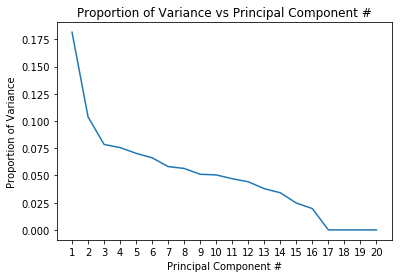

In [12]:
pca_plot(design(contra, phi0))

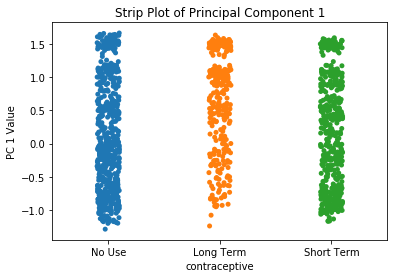

In [13]:
pca_plot(design(contra, phi0), 'first')

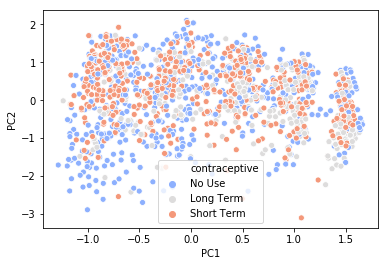

In [14]:
pca_plot(design(contra, phi0), "second")

Text(0.5, 1.0, 'Box Plot of Wife Age vs Contraceptive Method Used')

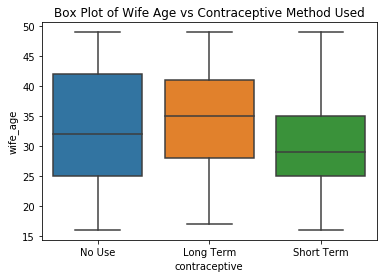

In [15]:
hues = contra['contraceptive'].replace({1: 'No Use', 2: "Long Term", 3 : "Short Term"})
sns.boxplot(x = hues, y = "wife_age", data = contra)
plt.title("Box Plot of Wife Age vs Contraceptive Method Used")

Text(0.5, 1.0, 'Proportion of Muslim and non Muslim Women for each contraceptive method used')

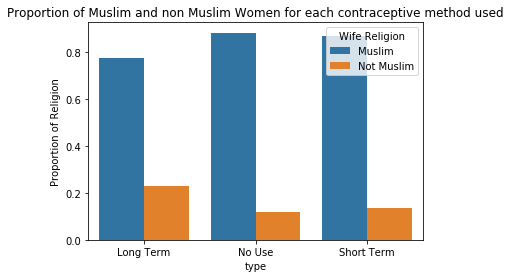

In [16]:
contra['Wife Religion'] = contra['wife_religion'].replace({0:"Not Muslim", 1 : "Muslim"})
def feature_percentage(feature):
    temp = contra.groupby(['type'])[feature].value_counts().groupby('type') \
        .apply(lambda x:  x / float(x.sum()))
    df = pd.DataFrame(temp)
    return df
df = feature_percentage("Wife Religion").rename(columns = {'Wife Religion' : 'Proportion of Religion'}).reset_index()
sns.barplot(x = "type", y = "Proportion of Religion",  hue = "Wife Religion", data = df)
plt.title("Proportion of Muslim and non Muslim Women for each contraceptive method used")

Standard of Living, Wife Edu, Husband Edu, all have very high percentages in the 'best' score for these categories, while short term is not as high. Maybe rich, more educated people tend to use birth
control more long term then short term, so even though the proportion of long term data is lower then short term, it may be easier to predict long term since so many of the long term ppl are so distincly educated and wealthy. This references the unexpected outcome of precision for short term vs long term. The no use was as expected, also was the highest proportion so the sheer amount of data likely overpowered the predictive power of long term. Note: This descrepancy occured in random forests but not in logistic regression. Ask TAS if we should be doing confusion matrix on test or train.

In [17]:
def rbf_feature(loc, x, beta=0.1):
    return np.exp(-((loc - x)**2)/beta)

In [18]:
def design2(X):
    X = X.copy()
    #want to predict standard_living
    categorical = X.copy()[['wife_education', 'husband_education', 'husband_occupation']]
    other = contra[['num_child', "wife_religion", "wife_work"]]
    
    #one hot encode the categorical data
    encoder = preprocessing.OneHotEncoder()
    one_hot = pd.DataFrame(encoder.fit_transform(categorical).toarray())
    ohe_columns = ["wife_edu1", "wife_edu2", "wife_edu3", "wife_edu4", "hus_edu1", "hus_edu2", "hus_edu3", "hus_edu4", 
           "hus_occ1", "hus_occ2", "hus_occ3", "hus_occ4"]
    one_hot.columns = ohe_columns
    contra_clean = other.join(one_hot)
    return phi(contra_clean, columns = ['num_child'])

#### Split cleaned data into train and test data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(design(contra, phi0), contra[['type']], test_size = .1, random_state = 42)

# Model 1. Logistic Regression

In [24]:
logistic_model = LogisticRegressionCV(multi_class = 'auto', max_iter = 1000, random_state=42)
logistic_model.fit(X_train, y_train)
y_hat = logistic_model.predict(X_train)

##### Precision vs Recall vs Accuracy

In [25]:
report = classification_report(y_train, y_hat)
print(report)

              precision    recall  f1-score   support

   Long Term       0.47      0.32      0.38       298
      No Use       0.58      0.63      0.60       560
  Short Term       0.46      0.51      0.48       467

   micro avg       0.52      0.52      0.52      1325
   macro avg       0.50      0.48      0.49      1325
weighted avg       0.51      0.52      0.51      1325



In [63]:
#plot_confusion_matrix(logistic_model, X_test, y_test)

##### Avergage Validation Accuracy

In [27]:
cross_val_avg = np.mean(cross_val_score(logistic_model, X_train, y_train))
print("Final Training Accuracy:", accuracy_score(y_hat, y_train))
print("Final Validation Accuacy:", cross_val_avg)

Final Training Accuracy: 0.5154716981132076
Final Validation Accuacy: 0.5200115822742299


In [28]:
y_hat_test = logistic_model.predict(X_test)
print("Final Test Accuracy:", accuracy_score(y_test, y_hat_test))

Final Test Accuracy: 0.5405405405405406


# Model 2. Decision Tree

In [93]:
def simple_model(model_name):
    train_acc, val_acc, test_acc = 0,0,0
    if model_name == 'decision tree':
        model = DecisionTreeClassifier(random_state = 10)
    elif model_name == 'random forest':
        model = RandomForestClassifier(n_estimators=2000, max_depth = 30, bootstrap =  True)
        
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, tree_model.predict(X_train))
    val_acc = np.mean(cross_val_score(tree_model, X_train, y_train))
    test_acc = accuracy_score(y_test, y_hat_test)
    return train_acc, val_acc, test_acc

In [47]:
def plot_graph(train_accuracy, val_accuracies, x_axis, name):
    plt.plot(x_axis, train_accuracy, label = "Training Accuracy")
    plt.plot(x_axis, val_accuracies, label = "Validation Accuracy")
    plt.legend(loc='best')
    xlabel, title = "", ""
    if name == 'num trees':
        xlabel = "Number of Trees"
        title = "Training & Validation Accuracies vs Number of Trees"
    elif name == 'max_features':
        xlabel = "Number of Trees"
        title = "Training & Validation Accuracies vs max features used."
    elif name == "depth":
        xlabel = "Depth"
        title = "Training & Validation Accuracies vs Depth"    
    else:
        xlabel = "Feature Functions"
        title = "Training & Validation Accuracies vs Different Feature Functions"
        plt.xticks(rotation=45)
    plt.ylabel('Accuracy')
    plt.xlabel(xlabel)
    plt.title(title)

In [42]:
def max_depth_tuning(model_name, max_depth, best_n_estimator = 1000):
    val_accuracies = []
    train_accuracies = []
    for d in max_depth:
        if model_name == 'decision tree':
            model = DecisionTreeClassifier(max_depth = d, random_state = 10)
        elif model_name == 'random forest':
            model = RandomForestClassifier(n_estimators = best_n_estimator, max_depth = d, bootstrap = True, random_state = 10)
        model.fit(X_train, y_train)
        train_accuracies.append(accuracy_score(y_train, model.predict(X_train)))
        cross_val_avg = np.mean(cross_val_score(model, X_train, y_train))
        val_accuracies.append(cross_val_avg)
    return train_accuracies, val_accuracies

### Attempt #1: Simple Naive model

In [94]:
train_acc, val_acc, test_acc = simple_model("decision tree")
print("Training Accuracy", train_acc)
print("Validation Accuracy", val_acc)
print("Test Accuracy:", test_acc)

Training Accuracy 0.9471698113207547
Validation Accuracy 0.4460754135432133
Test Accuracy: 0.5405405405405406


### Attempt #2: Tuning max depth

We get the best validation accuracy at depth:  4 with accuracy 0.5351099991054844


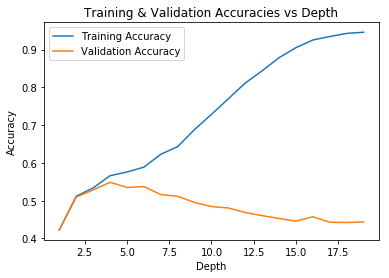

In [56]:
depth_range = np.arange(1,20)
train_acc, val_acc = max_depth_tuning("decision tree", depth_range)
plot_graph(train_acc,val_acc, depth_range, "depth")
best_depth = depth_range[np.argmax(val_acc)]
print("We get the best validation accuracy at depth: ", best_depth, "with accuracy", val_acc[best_depth])

### Attempt #3: Tuning max feartures

*Based on our previous result, we achieve the maximum validation accuracy at depth 4*

*We will fix depth =4  in the following max feature tuning*

In [59]:
def max_feature_tuning(min_samples_splits):
    val_accuracies = []
    train_accuracies = []
    for max_feature in max_features:
        dt= DecisionTreeClassifier(max_features=max_feature,max_depth = 4 , random_state = 10)
        dt.fit(X_train, y_train)
        train_accuracies.append(accuracy_score(y_train, dt.predict(X_train)))
        cross_val_avg = np.mean(cross_val_score(dt, X_train, y_train))
        val_accuracies.append(cross_val_avg)
    return train_accuracies, val_accuracies

We get the best validation accuracy with max features used  11 accuracy 0.5516790273861049


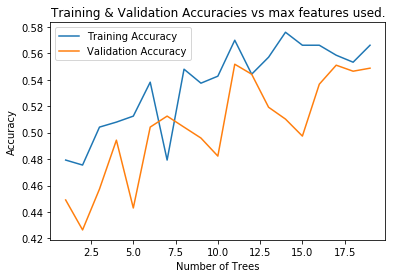

In [82]:
max_features = list(range(1,X_train.shape[1]))
train_acc, val_acc = max_feature_tuning(max_features)
plot_graph(train_acc, val_acc, max_features, "max_features")
best_features = max_features[np.argmax(val_acc)]
print("We get the best validation accuracy with max features used ", best_features,"accuracy", max(val_acc))

# Model 3. Random Forest

### Attempt #1: Simple Naive model

In [96]:
train_acc, val_acc, test_acc = simple_model("random forest")
print("Training Accuracy", train_acc)
print("Validation Accuracy", val_acc)
print("Test Accuracy:", test_acc)

Training Accuracy 0.9471698113207547
Validation Accuracy 0.4460754135432133
Test Accuracy: 0.5405405405405406


*Our simple model for random forest achieved 0.53962 average validation accuracy*

### Attempt #2:  Tuning number of trees

In [99]:
def num_trees_tuning(n_estimators):
    val_accuracies, train_accuracies = [], []
    for n in n_estimators:
        rf = RandomForestClassifier(n_estimators = n, max_depth = 30, bootstrap = True)
        rf.fit(X_train, y_train)
        train_accuracies.append(accuracy_score(y_train, rf.predict(X_train)))
        cross_val_avg = np.mean(cross_val_score(rf, X_train, y_train))
        val_accuracies.append(cross_val_avg)
    return train_accuracies, val_accuracies

In [100]:
n_estimators = np.arange(2000,6001, 500)
train_acc, val_acc = num_trees_tuning(n_estimators)


We get the best validation accuracy with  3000 number of trees and validation accuracy 0.5252837378617488


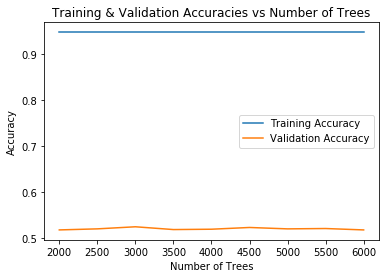

In [101]:
n_estimators = np.arange(2000,6001, 500)
plot_graph(train_acc, val_acc, n_estimators, 'num trees')
best_num = n_estimators[np.argmax(val_acc)]
print("We get the best validation accuracy with ", best_num, "number of trees and validation accuracy", max(val_acc))

*We can see that our validation accuracy drastically imporoved from 0.446 in our simple model to 0.525 upon num tres tuning!*

*Lets see if we can do better by tuning max depth of the trees!*

### Attempt #3: Max Depth Tuning

*Based on our previous result, we achieve the maximum validation accuracy at 3500 decision trees*

*We will fix n_estimators = 3500 in the following max depth tuning*

We get the best validation accuracy at depth:  6 and 3500 number of trees with accuracy 0.5494389236222991


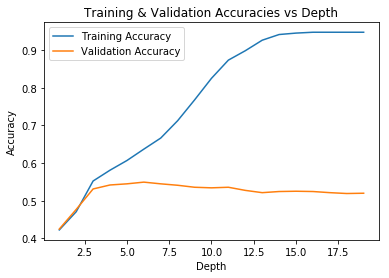

In [102]:
depth_range = np.arange(1,20)
train_acc, val_acc = max_depth_tuning("random forest", depth_range, 3000)
plot_graph(train_acc,val_acc, depth_range, "depth")
best_depth = depth_range[np.argmax(val_acc)]
print("We get the best validation accuracy at depth: ", best_depth, "and 3000 number of trees with accuracy", max(val_acc))

*After tuning the max depth of the trees, our validation score improved from 0.525 to 0.549!*

### Attempt #4: Mixed Hyperparameter Tuning

#### 1. Random Parameter Grid

In [20]:
#number of trees in random forest
n_estimators = np.arange(7000, 10001, 600)

#depth of the tree
max_depth = np.arange(10,120,20)

#minimum number of samples required to split the node
min_samples_split = [5,10,15,20]

#method of selecting samples for training each tree
#bootstrap = [True, False]


#random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
               #'bootstrap': bootstrap}

In [29]:
# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: could not convert string to float: 'No Use'

In [43]:
rf_random.best_params_

{'n_estimators': 7000, 'min_samples_split': 15, 'max_depth': 10}

#### 2. Grid Search

In [22]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10,15],
    'min_samples_split': [12,15,18],
    'n_estimators': [7000,7200,7500]
}


In [23]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2, random_state = 42)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: could not convert string to float: 'No Use'

#### 3. Design the model based on the optimal parameters found

In [38]:
rf_best = RandomForestClassifier(n_estimators=7200, max_depth = 10, min_samples_split = 18, bootstrap =  True, random_state=42)
cross_val_avg = np.mean(cross_val_score(rf_best, X_train, y_train))

In [39]:
print("Random Forest Cross Val Score for attempt #4")
cross_val_avg

Random Forest Cross Val Score for attempt #4


0.5479357350921553

*After utilizing Random Search and Grid Search to tune our hyperparameters, we concluded that using 7200 trees, a max depth of 10, and 18 as our minimum samples split optimizes our accuracy of our random forest model.*

*Our accuracy improved from 0.539 to 0.56528!*

## Feature Engineering

*Now we will try lifting the continuous variables to 
a new feature using various transformations*

In [32]:
def phi0(X, columns):

    for column in columns:
        X[column] = standardize(X[[column]])[column]
        
    return X

def phi1(X, columns):
    
    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        
    return X

def phi2(X, columns):

    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        X[column + "^2"] = X[column]**2
        
    return X

def phi3(X, columns):

    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        X[column + "^2"] = X[column]**2
        X[column + "^3"] = X[column]**3
        
    return X

def phi4(X, columns):
    
    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        X[column + "^2"] = X[column]**2
        X[column + "^3"] = X[column]**3
        X[column + "^4"] = X[column]**4
        
    return X

def phi5(X, columns):

    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        X[column + "^2"] = X[column]**2
        X[column + "^3"] = X[column]**3
        X[column + "^4"] = X[column]**4
        X[column + "^5"] = X[column]**5
        
    return X

def phi_ellipsoid(X, columns):
    
    for i in columns:
        X[i] = standardize(X[[i]])[i]
        for j in columns:
            if i == j:
                X[i + "^2"] = X[i]**2
            else:
                X[i + " * " + j] = X[i] * X[j]
    return X
                
def parabaloid(X, columns):
    
    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['norm^2_of_' + column] = np.linalg.norm(X[column])**2
        
    return X

feature_funcs = [phi0, phi1, phi2, phi3, phi4, phi5, phi_ellipsoid, parabaloid]



In [41]:
val_acc, train_acc = [], []
func_names = ['phi0', 'phi1', 'phi2', 'phi3', 'phi4', 'phi5', 'phi_ellipsoid', 'parabaloid']
for phi in feature_funcs:
    X_train, X_test, y_train, y_test = \
        train_test_split(design(contra, phi), contra[['contraceptive']], test_size = .1, random_state = 42)
    rf_best.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, rf_best.predict(X_train)))
    cross_val_avg = np.mean(cross_val_score(rf_best, X_train, y_train))
    val_acc.append(cross_val_avg)

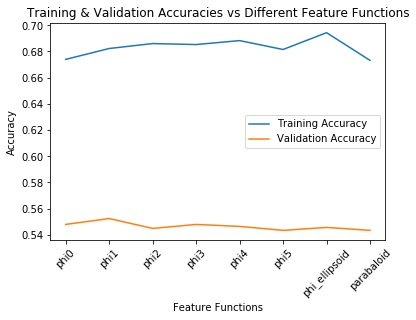

In [48]:
plot_graph(train_acc, val_acc, func_names, val_acc)

*Confusion Matrix for the best Random Forest Algorithm using the best feature function phi1*

In [80]:
X_train, X_test, y_train, y_test = \
        train_test_split(design(contra, phi1), contra[['type']], test_size = .1, random_state = 42)
rf_best.fit(X_train, y_train)
y_hat_train = rf_best.predict(X_train)
# confusion_matrix(y_test, y_hat)

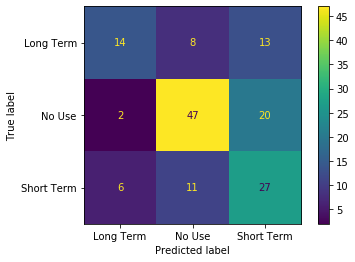

In [81]:
plot_confusion_matrix(rf_best, X_test, y_test)

In [88]:
print("Training Accuracy:", accuracy_score(y_train, y_hat_train))
print("Validation Accuracy:", np.mean(cross_val_score(rf_best, X_train, y_train)))

Training Accuracy: 0.6822641509433962
Validation Accuracy: 0.5683018867924529


In [89]:
y_hat_train = rf_best.predict(X_train)
print("Test Accuracy:", accuracy_score(y_test,y_hat))

Test Accuracy: 0.5945945945945946


In [83]:
report = classification_report(y_test, y_hat)
print(report)

              precision    recall  f1-score   support

   Long Term       0.64      0.40      0.49        35
      No Use       0.71      0.68      0.70        69
  Short Term       0.45      0.61      0.52        44

    accuracy                           0.59       148
   macro avg       0.60      0.56      0.57       148
weighted avg       0.62      0.59      0.60       148



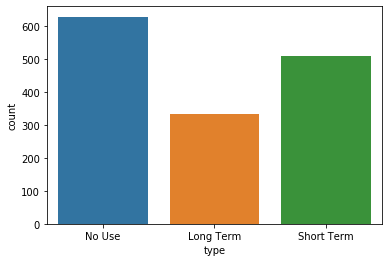

In [79]:
sns.countplot(data=contra, x = 'type')

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ 

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ 